In [1]:
import sys
# See which Python it's running
sys.executable

'/usr/local/Cellar/python/3.7.4_1/bin/python3.7'

In [19]:
# See where it's looking for imports
sys.path

['/Users/kibanez/git/STR_detection_python3',
 '/Users/kibanez/git/STR_detection_python3/venv/lib/python37.zip',
 '/Users/kibanez/git/STR_detection_python3/venv/lib/python3.7',
 '/Users/kibanez/git/STR_detection_python3/venv/lib/python3.7/lib-dynload',
 '/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7',
 '',
 '/Users/kibanez/git/STR_detection_python3/venv/lib/python3.7/site-packages',
 '/Users/kibanez/git/STR_detection_python3/venv/lib/python3.7/site-packages/IPython/extensions',
 '/Users/kibanez/.ipython']

In [20]:
import itertools
import numpy as np
import scipy
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
%matplotlib inline

In [21]:
import json
import os

In [24]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 16

Load data

In [49]:
# Note this input file has been "manipulated" for having 1 allele expanded (except for FXN)
repeat_sizes = pd.read_csv('/Users/kibanez/Documents/STRs/VALIDATION/table_validation_EHv255_for_swim_lane.tsv', sep='\t')
repeat_sizes.head()
#np.unique(repeat_sizes['locus_bioinfo'])
#np.unique(repeat_sizes['new_classification_avg'])
# array(['FN', 'FP', 'TN', 'TP'], dtype=object)

,locus_bioinfo,LP_Number,gender,EH_a1,EH_a2,experimental_a1,experimental_a2,EH_a1_avg,EH_a2_avg,EH_a1_maxCI,EH_a2_maxCI,classification,threshold_normal,threshold_pathogenic,new_classification_avg
0,AR,LP3000743-DNA_G05,NaN,55,62,expanded,expanded,62.0,NaN,72.0,NaN,TP,34,37,TP
1,AR,LP3001079-DNA_B02,NaN,44,57,expanded,expanded,57.0,NaN,64.0,NaN,TP,34,37,TP
2,AR,LP3000633-DNA_E05,NaN,51,na,expanded,NaN,52.0,NaN,55.0,NaN,TP,34,37,TP
3,AR,LP3001031-DNA_B11,NaN,42,44,expanded,expanded,43.0,NaN,43.0,NaN,TP,34,37,TP
4,AR,LP3000543-DNA_C11,NaN,40,40,expanded,expanded,40.0,NaN,40.0,NaN,TP,34,37,TP


Prepare data for plotting

In [50]:
repeat_info = {
    'AR':      {'expected_range': [34, 37],   'unit_len': 3, 'index': 12},
    'ATN1':    {'expected_range': [34, 47],   'unit_len': 3, 'index': 11},
    'ATXN1':   {'expected_range': [35, 43],   'unit_len': 3, 'index': 10},
    'ATXN2':   {'expected_range': [31, 32],   'unit_len': 3, 'index': 9},    
    'ATXN3':   {'expected_range': [43, 59],   'unit_len': 3, 'index': 8},    
    'ATXN7':   {'expected_range': [17, 35],   'unit_len': 3, 'index': 7},    
    'CACNA1A':   {'expected_range': [17, 19],   'unit_len': 3, 'index': 6},    
    'C9orf72':   {'expected_range': [30, 59],   'unit_len': 6, 'index': 5},        
    'FXN':     {'expected_range': [44, 65],   'unit_len': 3, 'index': 4},
    'HTT':     {'expected_range': [35, 39],   'unit_len': 3, 'index': 3},
    'TBP':    {'expected_range': [41, 48],   'unit_len': 3, 'index': 2},
    'FMR1':    {'expected_range': [49, 54],  'unit_len': 3, 'index': 1},
    'PPP2R2B':    {'expected_range': [32, 51],   'unit_len': 3, 'index': 0}    
}

In [53]:
# Function to map the colors as a list 
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l=='TP':
            cols.append('red')
        elif l=='TN':
            cols.append('blue')
        elif l=='FP':
            cols.append('blue')
        else:
            cols.append('red')
    return cols


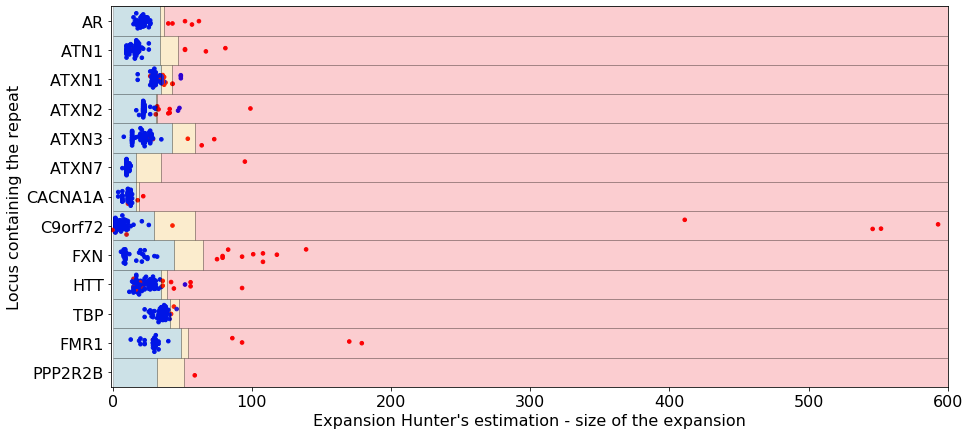

In [61]:
max_repeat_size = 600

fig, ax = plt.subplots(figsize=(15, 7))

for repeat_id, rec in repeat_sizes.groupby(by='locus_bioinfo'):
    normal_cutoff, premutation_cutoff = repeat_info[repeat_id]['expected_range']
    base_y = repeat_info[repeat_id]['index']
    
    ax.add_patch(patches.Rectangle((0, base_y - 0.5),
                                   normal_cutoff, 1.0,
                                   facecolor='#046b87', alpha=0.2, ec='k'))
    
    ax.add_patch(patches.Rectangle((normal_cutoff, base_y - 0.5),
                                   premutation_cutoff - normal_cutoff,
                                   1.0, facecolor='#eda407', alpha=0.2, ec='k'))

    ax.add_patch(patches.Rectangle((premutation_cutoff, base_y - 0.5),
                                   max_repeat_size - premutation_cutoff,
                                   1.0, facecolor='#ed0716', alpha=0.2, ec='k'))

    
    #allele_sizes = list(rec.max_EH_allele)
    allele_sizes = list(rec.EH_a1_avg) +  list(rec.EH_a2_avg)
    ys = np.random.normal(base_y, 0.12, len(allele_sizes))
    classi = list(rec.classification) + list(rec.classification)
    
    # Create the colors list using the function above
    cols=pltcolor(classi)

    # Distinguish each dot color depending on whether they are TP (red), TN (blue), FP (blue), FN (red)
    #ax.scatter(allele_sizes, ys, c='black')
    ax.scatter(allele_sizes, ys, c=cols, s=13)
    
    
    gene_names = [(gene, rec['index']) for gene, rec in repeat_info.items()]
    gene_names = sorted(gene_names, key=lambda k: k[1])
    gene_names = [g for g, _ in gene_names]
    ax.yaxis.set_ticks(range(0, len(gene_names)))
    ax.yaxis.set_ticklabels(gene_names)
    ax.margins(x=0, y=0)
    ax.set(xlabel='Expansion Hunter\'s estimation - size of the expansion', ylabel='Locus containing the repeat');

In [62]:
# Let's save the plot into a PDF file
fig.savefig("/Users/kibanez/Documents/STRs/PAPERS/VALIDATION_PAPER/Figures/repeat-sizes_EHa1_EHa2_average.pdf", bbox_inches='tight')

In [63]:
# Let's save the plot into a high quality PNG file
fig.savefig("/Users/kibanez/Documents/STRs/PAPERS/VALIDATION_PAPER/Figures/repeat-sizes_EHa1_EHa2_average.png", bbox_inches='tight', dpi=600)